## Introduction:       
In this notebook I have performed transfer learning on custom dataset with a pretrained object detection model. The dataset is a collection of images of water leaking from different faucets & fittings. This is a simulation model to detect leakages of liquids in an industrial setup.   
## Dataset:   
The data set contains 74 images dowloaded from the internet. I have labelled these images using an open source annotation tools called VGG image annotator 
There is another set of 24 images kept aside for testing. The target class is water droplet leaking out of a pipe fitting/joint.    
## Algorithm:
The algorithm is a pretrained FasteRCNN model with a RestNet50 network as backbone. This is a pretrained model on coco dataset. Only the final detection layers are modified to suit the number of target classes in our custom dataset. The accuracy of this model is good but the model suffers with slow inference speed. For realtime detection faster networks like ssd and yolo are more suitable 

In [13]:
import os
root='/content/drive/MyDrive/ComputerVision/ObjectDetection/LeakageDetection'
print(os.getcwd())
os.chdir(root)
print(os.getcwd())

!rm '/content/drive/MyDrive/ComputerVision/ObjectDetection/LeakageDetection/data/images/.DS_Store' 

/content/drive/MyDrive/ComputerVision/ObjectDetection/LeakageDetection
/content/drive/MyDrive/ComputerVision/ObjectDetection/LeakageDetection
rm: cannot remove '/content/drive/MyDrive/ComputerVision/ObjectDetection/LeakageDetection/data/images/.DS_Store': No such file or directory


In [14]:
import warnings
warnings.filterwarnings("ignore")
import json
import numpy as np
import pandas as pd
# image
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

# pytorch
import torch
import torch.utils.data
import utils
import transforms as T
from engine import train_one_epoch, evaluate
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Build the datasetloader**

In [15]:
class DropletDataset(torch.utils.data.Dataset):
    def __init__(self, root, label_file, image_path, transforms=None):
        # image_path="images/train"
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.labels = pd.read_csv(label_file, usecols = ['filename','region_shape_attributes'] )
        self.image_path=image_path
        self.imgs = list(sorted(os.listdir(os.path.join(root, self.image_path))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, self.image_path, self.imgs[idx])
        # print(img_path)
        img = Image.open(img_path).convert("RGB")
        img_fname=img_path.split('/')[-1]
        box= list(self.labels[self.labels['filename']==img_fname]['region_shape_attributes'])[0]
        # print(box)
        res = json.loads(box)
        xmin=res['x']
        ymin=res['y']
        xmax=xmin+res['width']
        ymax=ymin+res['height']
        boxes = []
        boxes.append([xmin,ymin,xmax,ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # There is only one class
        labels = torch.ones((1,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

**Load a pretrained model**

In [17]:


# load a detection model 
def get_object_detection_model(num_classes):
    """
    Methods loads a pretrained object detection model
    """
    # load a object detection pre-trained model on COCO
    model=torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


# apply transformations
def get_transform(train):
    """
    Method applies tranformations
    """
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


# Build the dataset class for train & test
train_dataset = DropletDataset(root, 'train.csv', 'images/train', get_transform(train=True))
test_dataset = DropletDataset(root, 'test.csv', 'images/test', get_transform(train=False))
                         
# Build the dataset loader for train & test
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
                                          batch_size=2, 
                                          shuffle=True, 
                                          num_workers=2,
                                          collate_fn=utils.collate_fn)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=1, 
                                          shuffle=True, 
                                          num_workers=2,
                                          collate_fn=utils.collate_fn)




**Check a sample from train**

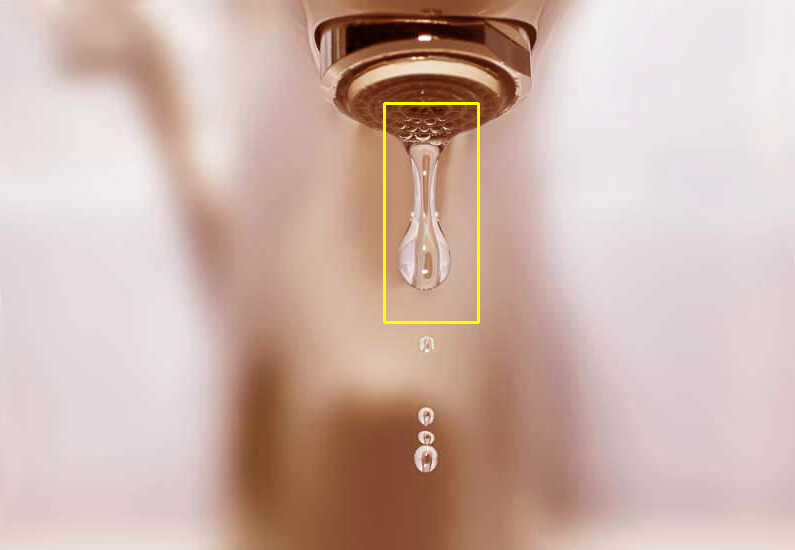

In [29]:
def view_img_bbox(bbox,img_arr, score=None):
    """
    Method shows bbox on images
    """
    start_point=(bbox[0],bbox[1])
    end_point=(bbox[2],bbox[3])

    image = cv2.rectangle(img_arr, start_point, end_point, color=(0,255,255), thickness=2)
    if score:
        image = cv2.putText(img=image, 
                            text=f'leakage: {str(score)}' , 
                            org=(25, 25), 
                            fontFace = cv2.FONT_HERSHEY_SIMPLEX,  
                            fontScale=0.5, 
                            color=(255, 0, 0), 
                            thickness=2)
    # dim=(500,500)
    # image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    # Displaying the image 
    cv2_imshow(image)
    return

# check a sample of train data
images,targets = next(iter(train_data_loader))
img = images[0].mul(255).permute(1, 2, 0).byte().numpy()
box = list(targets[0]['boxes'].cpu().numpy()[0])
bbox = [int(x) for x in box]

# call the helper function to load and view img, label
view_img_bbox(bbox,img)

In [19]:
def run():
    """
    Method runs the train and val
    """
    # background 0, droplet 1
    num_classes = 2
    # get the model 
    model = get_object_detection_model(num_classes)
    # Load model to GPU/CPU
    model.to(device)
    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, 
                                lr=0.005,
                                momentum=0.9, 
                                weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=3,
                                                    gamma=0.1)

    # train epochs
    num_epochs = 50

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        # evaluate(model, test_data_loader, device=device)

    return model

trained_model = run()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 96.1MB/s]


Epoch: [0]  [ 0/37]  eta: 0:01:07  lr: 0.000144  loss: 1.4914 (1.4914)  loss_classifier: 0.7727 (0.7727)  loss_box_reg: 0.0040 (0.0040)  loss_objectness: 0.6925 (0.6925)  loss_rpn_box_reg: 0.0221 (0.0221)  time: 1.8134  data: 0.7739  max mem: 3139
Epoch: [0]  [10/37]  eta: 0:00:08  lr: 0.001531  loss: 1.2912 (1.2158)  loss_classifier: 0.5723 (0.5126)  loss_box_reg: 0.0003 (0.0037)  loss_objectness: 0.6909 (0.6877)  loss_rpn_box_reg: 0.0096 (0.0118)  time: 0.3303  data: 0.1043  max mem: 3296
Epoch: [0]  [20/37]  eta: 0:00:05  lr: 0.002919  loss: 0.7946 (0.9096)  loss_classifier: 0.1471 (0.3152)  loss_box_reg: 0.0008 (0.0060)  loss_objectness: 0.6619 (0.5797)  loss_rpn_box_reg: 0.0055 (0.0087)  time: 0.2488  data: 0.1067  max mem: 3296
Epoch: [0]  [30/37]  eta: 0:00:02  lr: 0.004306  loss: 0.3357 (0.7202)  loss_classifier: 0.0935 (0.2660)  loss_box_reg: 0.0241 (0.0177)  loss_objectness: 0.1156 (0.4250)  loss_rpn_box_reg: 0.0053 (0.0114)  time: 0.3167  data: 0.1830  max mem: 3587
Epoch: [

**Save the model**

In [23]:
# Specify a path
PATH = f"leakage_detection_model_{time.time()}.pt"

# Save
torch.save(trained_model, PATH)

**Load the trained model**

In [ ]:
# PATH = "leakage_detection_model_1681583049.9375646.pt"
# Load
model = torch.load(PATH)
model.eval()

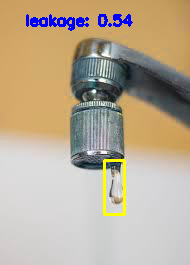

inference time: 0.05 sec(s)


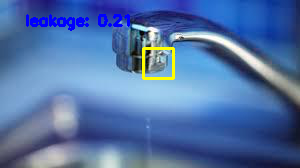

inference time: 0.05 sec(s)


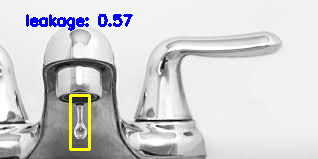

inference time: 0.04 sec(s)


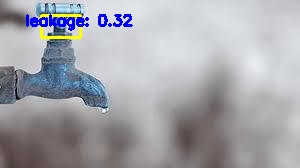

inference time: 0.5 sec(s)


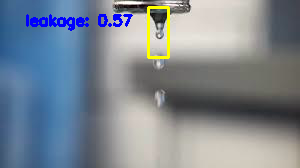

inference time: 0.38 sec(s)


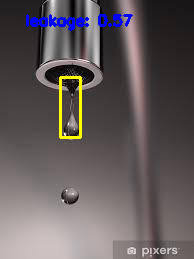

inference time: 0.44 sec(s)


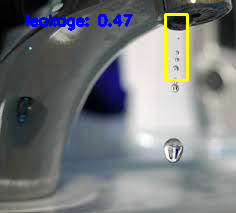

inference time: 0.53 sec(s)


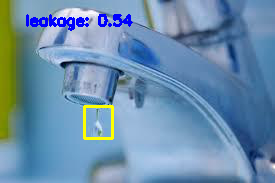

inference time: 0.41 sec(s)


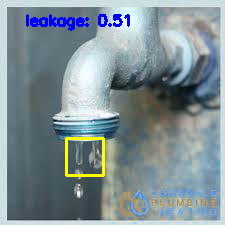

inference time: 0.45 sec(s)


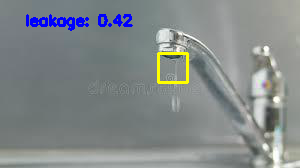

inference time: 0.45 sec(s)


In [26]:
def inference(trained_model, i):
    """
    Perform inference on a image from testset
    """
    img, _ = test_dataset[i]
    # print(img)
    # put the model in evaluation mode
    trained_model.eval()
    with torch.no_grad():
        prediction = trained_model([img.to(device)])
    # print(prediction)
    box = list(prediction[0]['boxes'].cpu().numpy()[0])
    score = round(prediction[0]['scores'].cpu().numpy()[0], 2)
    bbox = [int(x) for x in box]
    img=img.mul(255).permute(1, 2, 0).byte().numpy()
    return bbox,img,score

import time
# inference on multiple images from test
for i in range(10):
    st=time.time()
    bbox,img,score = inference(model, i=i)
    view_img_bbox(bbox,img,score)
    et=time.time()
    print(f'inference time: {round(et-st,2)} sec(s)')

# inference on a single image from test
# for i in range(3):
# bbox,img,score = inference(trained_model, i=4)
# view_img_bbox(bbox,img, score)
